# Metastatic Cancer Detection using Binary Image Classification

This notebook presents a complete workflow for identifying metastatic cancer in small image patches extracted from larger digital pathology scans.  The project is structured into five steps:

1. **Problem and data description** – What is the task and how is the data structured?
2. **Exploratory Data Analysis (EDA)** – Inspect, visualize and clean the data.
3. **Model architecture and tuning** – Build and compare several convolutional neural network (CNN) architectures, including transfer learning.
4. **Results and analysis** – Evaluate the models, present metrics and discuss performance.
5. **Conclusion** – Summarize the findings and identify future improvements.

### Data Import

In [ ]:
# Add libraries to runtime
!pip install tensorflow_io

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import tensorflow_io as tfio

/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

In [2]:
# Log into Kaggle to access dataset
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# Import data to colab cache
histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')
print('Data source import complete.')

# Move from cache to kaggle folder
!mkdir -p /kaggle/histopathologic-cancer-detection
!cp -r /root/.cache/kagglehub/competitions/histopathologic-cancer-detection/* /kaggle/histopathologic-cancer-detection/

# Remove download from cache
!rm -rf /root/.cache/kagglehub/competitions/histopathologic-cancer-detection

100%|██████████| 6.31G/6.31G [00:59<00:00, 114MB/s]

Extracting files...


Data source import complete.


In [4]:
!ls /kaggle/histopathologic-cancer-detection

sample_submission.csv  test  train  train_labels.csv


## Step 1: Problem and data description

The goal is to train a binary image classifier to determine whether a 96×96 pixel RGB patch of a digital pathology slide contains metastatic tissue.  The training set consists of 220,025 image patches collected from lymph‑node biopsies.  Each sample is labelled with `0` (no metastasis) or `1` (metastasis).  According to the competition description, a positive label indicates that the central 32×32 pixel region of the patch contains at least one pixel of tumour tissue; tumour tissue in the outer region does not influence the label.  The outer region is provided so that fully convolutional models can be trained without zero padding.

Basic statistics from the training metadata show that there are 130,908 negative samples and 89,117 positive samples (≈40.5 % positive).  The class imbalance is moderate, so special care may be needed during training.  The `train_labels.csv` file contains two columns: `id` (the image file name without extension) and `label` (0 or 1).  Only the training set has labels; test images are provided without labels for competition evaluation.

In [10]:
# Define dataset paths relative to the local repository
train_dir = '/kaggle/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/histopathologic-cancer-detection/test/'
labels_csv = '/kaggle/histopathologic-cancer-detection/train_labels.csv'
sample_submission_csv = '/kaggle/histopathologic-cancer-detection/sample_submission.csv'

labels_df = pd.read_csv(labels_csv)

# Display the first few rows
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Class counts:
label
0    130908
1     89117
Name: count, dtype: int64


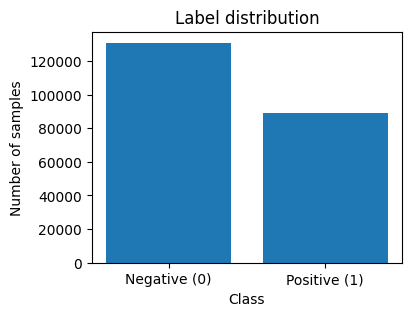

In [11]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Label distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

## Step 2: Exploratory Data Analysis (EDA)

In this section we inspect the data visually and numerically.  We load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, we use the Pillow library to read them.  We also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive).  To mitigate bias during training, you may explore class weighting or resampling strategies.

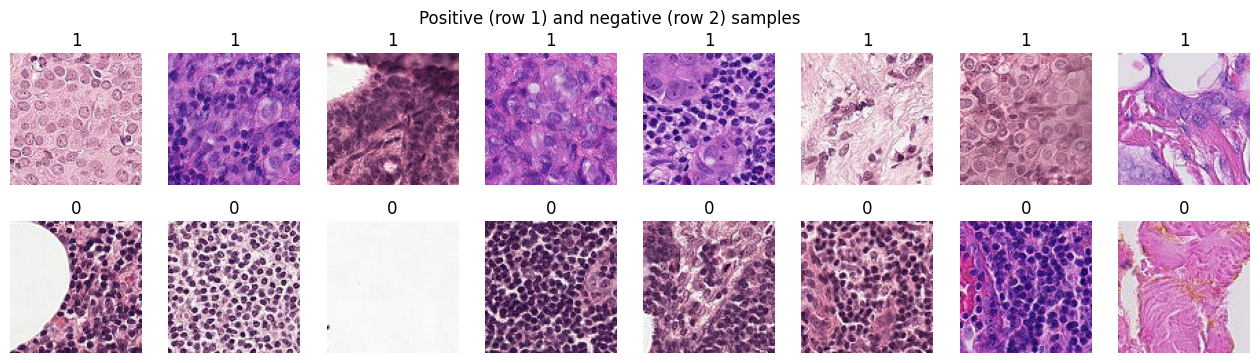

In [18]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_dir)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_dir)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

In [27]:
# Compute global channel mean and standard deviation (optional but useful for normalization)
def compute_channel_stats(image_ids, image_dir, sample_size=2000):
    sample_ids = np.random.choice(image_ids, size=min(sample_size, len(image_ids)), replace=False)
    channel_sum = np.zeros(3)
    channel_sum_sq = np.zeros(3)
    total_pixels = 0
    for img_id in tqdm(sample_ids, desc='Computing statistics'):
        img = np.array(load_image(img_id, image_dir)) / 255.0
        channel_sum += img.sum(axis=(0, 1))
        channel_sum_sq += (img ** 2).sum(axis=(0, 1))
        total_pixels += img.shape[0] * img.shape[1]
    mean = channel_sum / total_pixels
    std = np.sqrt(channel_sum_sq / total_pixels - mean ** 2)
    return mean, std

# Compute statistics
mean, std = compute_channel_stats(labels_df['id'].values, train_dir, sample_size=5000)
print('Channel means:', mean,'\n')
print('Channel stds:', std)

Computing statistics: 100%|██████████| 5000/5000 [00:16<00:00, 300.71it/s]

Channel means: [0.70105632 0.54403426 0.69557632]
Channel stds: [0.23897354 0.28151721 0.21583732]


Based on the EDA, the following observations guide our analysis:

- The label distribution shows a moderate class imbalance; using class weights or oversampling may help the model focus on minority (positive) samples.
- The images have strong staining variability and sometimes contain artefacts; data augmentation (random flips, rotations, brightness/contrast adjustments) can improve generalisation.
- Normalising images with per-channel mean and standard deviation computed above can stabilise training.

**Analysis plan:**

1. Split the labelled data into training and validation sets (e.g. 80/20).
2. Preprocess images: resize to a common size (96×96), apply augmentations on the fly, and normalise by global channel statistics.
3. Train several CNN architectures ranging from a simple custom CNN to transfer learning models (e.g. ResNet50, DenseNet169).
4. Tune hyperparameters such as learning rate, optimiser, dropout rate, batch size and number of layers using a search strategy (random search or Bayesian optimisation).
5. Evaluate the models on the validation set using metrics appropriate for class imbalance (AUC, precision, recall, F1).

## Step 3: Model architecture and tuning

### Data loading and augmentation

TensorFlow’s `tf.data` API is used to load images and apply augmentations.  `image_dataset_from_directory` reads the images and labels directly from the file structure.  You can adjust the `batch_size` and augmentation parameters.

In [ ]:
from PIL import Image
import os
import glob

# Convert all .tif files in train_dir to .png
for tif_path in tqdm(glob.glob(os.path.join(train_dir, "*.tif"))):
    png_path = tif_path.replace(".tif", ".png")
    with Image.open(tif_path) as im:
        # ensure 3 channels (RGB); .tif images may be single‑channel
        rgb_im = im.convert('RGB')
        rgb_im.save(png_path)

 45%|████▌     | 99606/220025 [06:24<09:00, 222.92it/s]

In [ ]:
# Create training and validation datasets
batch_size = 64
img_size = (96, 96)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    # class_names = ['0', '1'],
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=batch_size,
    image_size=img_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    # class_names = ['0', '1'],
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=batch_size,
    image_size=img_size
)

# Normalization layer (replace 'mean' and 'std' with values computed above)
normalizer = tf.keras.layers.Rescaling(1./255)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
])